In [1]:
import pandas as pd
from enum import Enum
from operator import itemgetter
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
%matplotlib inline

In [2]:
class PredictionType(Enum):
    CLASSIFICATION = 1
    REGRESSION = 2

In [3]:
from operator import itemgetter
import matplotlib.pyplot as plt
import numpy as np

class SimpleKNN:
    
    def fit(self, X_train: np.matrix, y_train: np.ndarray):
        """
        Метод обучения, который фактически не учится, 
        а только запоминает обучающую выборку.
        Входные параметры:
        X_train - обучающая выборка (матрица объект-признак)
        y_train - обучающая выборка (вектор целевого признака)
        Возвращаемое значение: нет
        """
        #Сохраняем параметры в переменных класса
        self._X_train = X_train
        self._y_train = y_train
          
    def eucl_dist(self, p: np.ndarray, q: np.ndarray) -> float:
        """
        Вычисление Евклидова расстояния - https://en.wikipedia.org/wiki/Euclidean_distance 
        Входные параметры:
        p, q - вектора в n-мерном пространстве признаков
        """
        return sum([(pi - qi) ** 2 for pi, qi in zip (p, q)])
            
            
    def predict_for_single_object(self, K: int, \
                prediction_type: PredictionType, \
                X_o: np.ndarray, \
                verbose = True) -> np.ndarray:
        """
        Метод предсказания для одного объекта.
        Входные параметры:
        K - гиперпараметр, количество соседей 
        prediction_type - классификация или регрессия 
        X_o - строка матрицы объект-признак, соответствующая объекту
        verbose - флаг детального вывода
        Возвращаемое значение: предсказанное значение целевого признака
        """
        # список соседей
        neighbors_list = []
        # *** Находим ближайшие точки ***
        # Перебираем все точки обучающей выборки
        for i in range(self._X_train.shape[0]):
            # получаем текущую точку
            data_train_current_x = [x for x in self._X_train[['x1','x2']].iloc[i]]
            # и значение ее y
            data_train_current_y = self._y_train[i]
            # вычисляем расстояние
            dist = self.eucl_dist(X_o, data_train_current_x)
            # сохраняем в список соседей
            temp_res = (data_train_current_y, dist, data_train_current_x)
            neighbors_list.append(temp_res)
        # *** сортируем список соседей по возрастанию расстояния *** 
        # в кортеже элементы следуют в порядке (0,1,2), сортируем по первому элементу 
        neighbors_list_sorted = sorted(neighbors_list, key=itemgetter(1))
        if verbose:
            print()
            print('**************************************')
            print('Проверяемая точка: ', X_o)
            print('**************************************')
            print('Вывод отсортированного списка соседей:')    
            dist_list = []
            for cur_y, cur_dist, _ in neighbors_list_sorted:
                print('y={0}, расстояние={1:.2f}'.format(cur_y, cur_dist))
                dist_list.append(cur_dist)
            print()
            print('Вывод расстояния для отсортированного списка соседей:')    
            plt.plot(dist_list)
            plt.show()
        # Оставим только K ближайших соседей
        K_neighbors_list_sorted = neighbors_list_sorted[:K]
        if verbose:
            print('Вывод К ближайших соседей:')
            x1_list = []
            x2_list = []
            for cur_y, cur_dist, temp_x_1_2 in K_neighbors_list_sorted:
                temp_x1, temp_x2 = temp_x_1_2
                x1_list.append(temp_x1)
                x2_list.append(temp_x2)
                print('y={0}, расстояние={1:.2f}'.format(cur_y, cur_dist))
            print()
            print('Визуализация К ближайших соседей:')
            plt.plot(self._X_train['x1'], self._X_train['x2'], 'b.', \
                     x1_list, x2_list,  'g*', \
                    [X_o[0]], [X_o[1]], 'ro')
            plt.show()   
        # Результат - классификация или регрессия
        if prediction_type == PredictionType.REGRESSION:
            # используем numpy для вычисления среднего значения
            arr = np.array([x for x,_,_ in K_neighbors_list_sorted])
            # возвращаем среднее значение
            return np.mean(arr)          
        elif prediction_type == PredictionType.CLASSIFICATION:
            k_y_list = [y for y,_,_ in K_neighbors_list_sorted]
            # группируем с количеством метки классов,
            # соответствующие K ближайшим соседям
            k_y_list_grouped_temp = np.unique(k_y_list, return_counts=True)
            k_y_list_grouped = [[key, cnt] for key, cnt in zip(k_y_list_grouped_temp[0], k_y_list_grouped_temp[1])]
            # сортируем по количеству по убыванию
            k_y_list_grouped_sorted = sorted(k_y_list_grouped, key=itemgetter(1), reverse=True)
            if verbose:
                print('Классы, соответствующие К ближайшим соседям:')
                for i in k_y_list_grouped_sorted:
                    print('класс={0}, количество элементов={1}'.format(i[0], i[1]))
            # возвращаеv метку класса из первой строки отсортированного массива
            # то есть того класса, к которому принадлежит наибольшее количество соседей
            return k_y_list_grouped_sorted[0][0]
        else:
            raise Exception('Неизвестный тип предсказания')
                   
    
    def predict(self, K: int, \
                prediction_type: PredictionType, \
                X_test: np.matrix, 
                verbose = True) -> np.ndarray:
        """
        Метод предсказания.
        Входные параметры:
        K - гиперпараметр, количество соседей 
        prediction_type - классификация или регрессия 
        X_test - тестовая выборка (матрица объект-признак)
        Возвращаемое значение: предсказанный вектор целевого признака
        """
        # Перебираем все точки тестовой выборки
        test_data_temp = []
        for i in range(X_test.shape[0]):
            # получаем текущую точку
            data_test_current_x = [x for x in X_test.iloc[i]]
            test_data_temp.append(data_test_current_x)       
        return [self.predict_for_single_object(K=K, \
                prediction_type=prediction_type, \
                X_o=i, verbose=verbose) for i in test_data_temp]

In [4]:
data = pd.read_csv('winequality-red.csv')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
data.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

<BarContainer object of 1599 artists>

<Figure size 720x432 with 0 Axes>

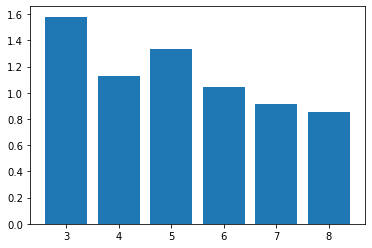

In [6]:
# Выберем критерии для построения модели. От каких параметров зависит качество вина?
fig = plt.figure(figsize = (10,6))
x = data['quality'].values
y = data['volatile acidity'].values 
fig = plt.figure()
plt.bar(x, y)
# на этом графике прослеживается обратная зависимость между летучей кислотностью и качеством вина

<BarContainer object of 1599 artists>

<Figure size 720x432 with 0 Axes>

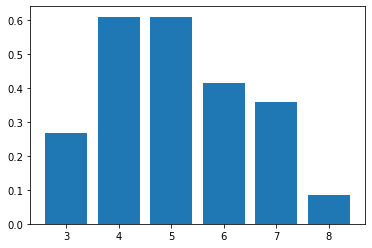

In [7]:
fig = plt.figure(figsize = (10,6))
x = data['quality'].values
y = data['chlorides'].values 
fig = plt.figure()
plt.bar(x, y)
# прямой зависимости нет. При низком уровне хлоридов 
# вино может быть как высококачественным, так и нет.
# У других критериев зависимость прослеживается еще хуже,
# так что возьму этот.

In [8]:
# Целевой признак y предназначен для регресии. Построим на его основе признак для классификации.
# 1 - высокое качество, 2 - среднее, 3 - низкое
def regr_to_class(y: float) -> str:
    if y < 5:
        result = '3'
    elif y < 7:
        result = '2'
    else:
        result = '1'        
    return result 
data['y_class'] = \
data.apply(lambda row: regr_to_class(row['quality']),axis=1)

In [9]:
# оставим толлько нужное
df = data[['volatile acidity', 'chlorides','y_class']]
df.columns=['x1', 'x2', 'y']
df.head()

,x1,x2,y
0,0.70,0.076,2
1,0.88,0.098,2
2,0.76,0.092,2
3,0.28,0.075,2
4,0.70,0.076,2


In [52]:
features = df.drop(['y'],axis=1)
target = df['y']

In [10]:
# разделим выборку на обучающую и тестовую
from sklearn.model_selection import train_test_split
X = df.drop('y', axis = 1 )
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [11]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)
X_train

array([[ 0.6648928 , -0.45362151],
       [-0.62346154, -0.36954631],
       [-1.07158479, -0.78992229],
       ...,
       [ 1.08500835,  0.61833724],
       [ 0.55286199,  0.19796126],
       [-0.73549236, -0.34852751]])

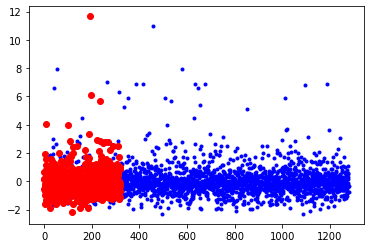

In [12]:
# визуализация выборки
plt.plot(X_train, 'b.', \
         X_test, 'ro')
plt.show() 

# Использование sklearn для классификации

In [13]:
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

In [14]:
#2 ближайших соседа
cl1 = KNeighborsClassifier(n_neighbors=1)
cl1.fit(X_train,y_train)
target1 = cl1.predict(X_test)
len(target1), target1

(320,
 array(['2', '2', '2', '2', '2', '1', '2', '2', '2', '2', '2', '2', '2',
        '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '1', '2', '2',
        '1', '2', '2', '2', '2', '2', '2', '2', '2', '1', '2', '2', '2',
        '2', '2', '1', '2', '2', '3', '1', '2', '2', '2', '1', '2', '2',
        '1', '2', '1', '2', '1', '2', '1', '2', '1', '2', '2', '2', '2',
        '2', '2', '3', '1', '1', '2', '1', '2', '2', '2', '2', '2', '2',
        '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2',
        '1', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2',
        '2', '2', '2', '2', '1', '2', '2', '2', '2', '2', '2', '1', '2',
        '2', '2', '2', '2', '2', '2', '3', '2', '2', '2', '2', '2', '2',
        '2', '2', '1', '2', '2', '1', '2', '2', '2', '1', '2', '2', '2',
        '3', '1', '2', '2', '2', '1', '3', '2', '2', '2', '2', '2', '2',
        '1', '2', '2', '2', '2', '2', '2', '2', '2', '2', '1', '2', '2',
        '2', '2', '2', '2', '2', '2', '1', '2

In [15]:
#10 ближайших соседей
cl2 = KNeighborsClassifier(n_neighbors=10)
cl2.fit(X_train,y_train)
target2 = cl2.predict(X_test)
len(target2), target2

(320,
 array(['2', '2', '2', '2', '2', '2', '1', '2', '2', '2', '2', '2', '2',
        '2', '1', '2', '2', '2', '2', '2', '2', '2', '2', '1', '2', '2',
        '1', '2', '2', '2', '2', '1', '2', '1', '2', '1', '2', '2', '1',
        '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '1', '2', '2',
        '1', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2',
        '2', '2', '2', '2', '2', '2', '1', '2', '2', '2', '2', '2', '2',
        '2', '2', '1', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2',
        '2', '2', '2', '2', '2', '2', '2', '2', '1', '2', '2', '2', '2',
        '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '1', '2',
        '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2',
        '2', '2', '1', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2',
        '2', '1', '2', '2', '2', '2', '2', '2', '1', '2', '2', '2', '2',
        '1', '2', '2', '2', '1', '1', '2', '2', '2', '2', '1', '2', '2',
        '2', '2', '2', '2', '2', '1', '2', '2

# Метрики качества классификации

In [16]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score
#для 1 соседа
accuracy_score(y_test, target1)

0.7625

In [17]:
#для 10 соседей
accuracy_score(y_test, target2)

0.803125

In [26]:
#матрица ошибок
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, target1)

array([[ 10,  22,   0],
       [ 31, 234,   9],
       [  3,  11,   0]], dtype=int64)

In [40]:
from sklearn.metrics import precision_score
print("precision_score()         : ",  precision_score(y_test, target2, average='micro'))

precision_score()         :  0.803125


In [42]:
from sklearn.metrics import f1_score, classification_report
print(classification_report(y_test, target1, target_names=y_test.drop_duplicates()))

              precision    recall  f1-score   support

           2       0.23      0.31      0.26        32
           1       0.88      0.85      0.87       274
           3       0.00      0.00      0.00        14

    accuracy                           0.76       320
   macro avg       0.37      0.39      0.38       320
weighted avg       0.77      0.76      0.77       320



# Cross-validation

In [55]:
from sklearn.model_selection import cross_val_score, cross_validate
scores = cross_val_score(KNeighborsClassifier(n_neighbors=2), 
                         features, target, cv=3)
scores

array([0.72983114, 0.72045028, 0.71669794])

In [57]:
# Усредненное значение метрики accuracy для 3 фолдов
np.mean(scores)

0.7223264540337712

In [59]:
# использование метрики f1
scores = cross_val_score(KNeighborsClassifier(n_neighbors=2), 
                         features, target, cv=3,
                        scoring='f1_weighted')
scores, np.mean(scores)

(array([0.72525814, 0.72776421, 0.72096823]), 0.724663528454427)

In [60]:
scoring = {'precision': 'precision_weighted', 
           'recall': 'recall_weighted',
           'f1': 'f1_weighted'}

In [62]:
scores = cross_validate(KNeighborsClassifier(n_neighbors=2), 
                        features, target, scoring=scoring, 
                        cv=3, return_train_score=True)
scores

{'fit_time': array([0.00475407, 0.01417732, 0.        ]),
 'score_time': array([0.06089926, 0.04818606, 0.06365204]),
 'test_precision': array([0.7505284 , 0.7400799 , 0.72948646]),
 'train_precision': array([0.91998785, 0.9133126 , 0.92034524]),
 'test_recall': array([0.72983114, 0.72045028, 0.71669794]),
 'train_recall': array([0.90150094, 0.8902439 , 0.89962477]),
 'test_f1': array([0.72525814, 0.72776421, 0.72096823]),
 'train_f1': array([0.89190066, 0.879706  , 0.88945397])}

In [65]:
from sklearn.model_selection import KFold, RepeatedKFold, LeaveOneOut, LeavePOut, ShuffleSplit, StratifiedKFold
X = range(12)
kf = RepeatedKFold(n_splits=3, n_repeats=2)
for train, test in kf.split(X):
    print("%s %s" % (train, test))

[0 1 3 4 5 7 8 9] [ 2  6 10 11]
[ 2  3  4  5  6  9 10 11] [0 1 7 8]
[ 0  1  2  6  7  8 10 11] [3 4 5 9]
[ 2  3  4  6  7  9 10 11] [0 1 5 8]
[ 0  1  5  6  7  8  9 10] [ 2  3  4 11]
[ 0  1  2  3  4  5  8 11] [ 6  7  9 10]


In [66]:
X = range(12)
# Эквивалент KFold(n_splits=n)
kf = ShuffleSplit(n_splits=5, test_size=0.25)
for train, test in kf.split(X):
    print("%s %s" % (train, test))

[ 1  4 10  7  6  0  9 11  3] [8 2 5]
[ 6 11  3 10  2  5  7  4  9] [8 0 1]
[ 9  6  8 10 11  0  2  5  4] [1 3 7]
[ 6  9  8  1  4  3 11  0  2] [ 7 10  5]
[ 8  1  9  4  0 11  7  2  6] [ 5 10  3]


In [67]:
#Grid Search (решетчатый поиск)
n_range = np.array(range(5,55,5))
tuned_parameters = [{'n_neighbors': n_range}]
tuned_parameters

[{'n_neighbors': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])}]

In [69]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
clf_gs = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, scoring='accuracy')
clf_gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_neighbors': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [70]:
clf_gs.cv_results_

{'mean_fit_time': array([0.00429668, 0.0018321 , 0.0015305 , 0.00197325, 0.00673361,
        0.00600233, 0.00398626, 0.0042356 , 0.00556345, 0.00322609]),
 'std_fit_time': array([0.00307001, 0.00366421, 0.00189685, 0.00163367, 0.00489949,
        0.00109136, 0.00213479, 0.0023889 , 0.00137372, 0.00116619]),
 'mean_score_time': array([0.02058072, 0.02559185, 0.03075414, 0.03192902, 0.0274797 ,
        0.02965107, 0.03246536, 0.03793678, 0.02883825, 0.02128735]),
 'std_score_time': array([0.00471597, 0.00859289, 0.00574594, 0.00277884, 0.00805261,
        0.00516102, 0.00833131, 0.0031426 , 0.00435883, 0.00301588]),
 'param_n_neighbors': masked_array(data=[5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 5},
  {'n_neighbors': 10},
  {'n_neighbors': 15},
  {'n_neighbors': 20},
  {'n_neighbors': 25},
  {'n_neig

In [71]:
# Лучшая модель
clf_gs.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=25, p=2,
                     weights='uniform')

In [72]:
# Лучшее значение метрики
clf_gs.best_score_

0.809234068627451

In [73]:
# Лучшее значение параметров
clf_gs.best_params_

{'n_neighbors': 25}

In [88]:
# Изменение качества на обучающей выборке
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
plt.plot(n_range, clf_gs.cv_results_['mean_train_score'])

KeyError: 'mean_train_score'

In [75]:
#Обучение модели и оценка качества с учетом подобранных гиперпараметров
clf_gs.best_estimator_.fit(X_train, y_train)
target2_0 = clf_gs.best_estimator_.predict(X_train)
target2_1 = clf_gs.best_estimator_.predict(X_test)

In [76]:
# Новое качество модели
accuracy_score(y_train, target2_0), accuracy_score(y_test, target2_1)

(0.8209538702111024, 0.840625)

In [84]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'c:\\users\\пк\\appdata\\local\\programs\\python\\python38\\lib\\site-packages\\matplotlib\\pyplot.py'>

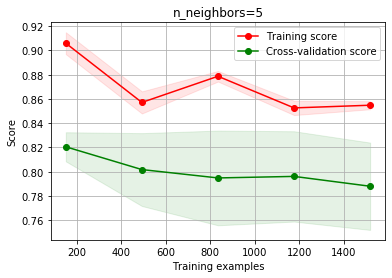

In [85]:
from sklearn.model_selection import learning_curve, validation_curve
plot_learning_curve(KNeighborsClassifier(n_neighbors=5), 'n_neighbors=5', 
                    features, target, cv=20)

In [89]:
def plot_validation_curve(estimator, title, X, y, 
                          param_name, param_range, cv, 
                          scoring="accuracy"):
                                                   
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'c:\\users\\пк\\appdata\\local\\programs\\python\\python38\\lib\\site-packages\\matplotlib\\pyplot.py'>

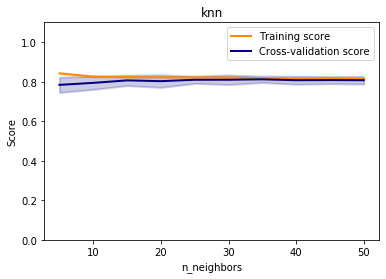

In [90]:
plot_validation_curve(KNeighborsClassifier(), 'knn', 
                      X_train, y_train, 
                      param_name='n_neighbors', param_range=n_range, 
                      cv=20, scoring="accuracy")